In [312]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
import os
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import sys
from torch.utils.data import DataLoader, TensorDataset

from numpy import linalg as LA

## Loading the dataset and split into train,validationa nd test

In [388]:
S1=np.loadtxt('S11_batch4K.txt') # 4096 samples
# S2=np.loadtxt('S11_batch8K.txt')
# S1=np.concatenate((S1,S2),axis=0)

S11=np.delete(S1,[499,572,874,1165,1308,2204,2754,3635],axis=0)

x1=np.loadtxt("X_batch4K.txt")
x1=x1[:,0:8]

y1=np.loadtxt("Y_batch4K.txt")
y1=y1[:,0:8]

# XX=np.concatenate((x1,x2),axis=0)
# YY=np.concatenate((y1,y2),axis=0)
# # print(S1.shape,x1.shape,y1.shape)
# xy=np.concatenate((XX,YY),axis=1)
# x1 = np.concatenate((x1,x2),axis=0)
# y1 = np.concatenate((y1,y2),axis=0)

xy=np.concatenate((x1,y1),axis=1)
xx=np.delete(xy,[499,572,874,1165,1308,2204,2754,3635],axis=0)


print(xx.shape,S11.shape)

import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Split ratios: 7:2:1
total_size = len(xx)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate sizes of each set
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split data
X_train = torch.tensor(xx[:train_size], dtype=torch.float32)
X_val = torch.tensor(xx[train_size:train_size + val_size], dtype=torch.float32)
X_test = torch.tensor(xx[train_size + val_size:], dtype=torch.float32)

y_train = torch.tensor(S11[:train_size], dtype=torch.float32)
y_val = torch.tensor(S11[train_size:train_size + val_size], dtype=torch.float32)
y_test = torch.tensor(S11[train_size + val_size:], dtype=torch.float32)

# Print shapes for verification
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

# Convert to TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage of train_loader, val_loader, and test_loader
for inputs, targets in train_loader:
    print('Batch from training loader:', inputs.shape, targets.shape)
    break

for inputs, targets in val_loader:
    print('Batch from validation loader:', inputs.shape, targets.shape)
    break

for inputs, targets in test_loader:
    print('Batch from test loader:', inputs.shape, targets.shape)
    break


(4088, 16) (4088, 128)
X_train: torch.Size([2861, 16]) X_val: torch.Size([817, 16]) X_test: torch.Size([410, 16])
y_train: torch.Size([2861, 128]) y_val: torch.Size([817, 128]) y_test: torch.Size([410, 128])
Batch from training loader: torch.Size([32, 16]) torch.Size([32, 128])
Batch from validation loader: torch.Size([32, 16]) torch.Size([32, 128])
Batch from test loader: torch.Size([32, 16]) torch.Size([32, 128])


## Define model

In [358]:
# Bayesian Neural Network with Monte Carlo Dropout
class BNN(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.3):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(p=dropout_prob)
        self.fc4 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


## Function to train the model

In [359]:
def train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=100, batch_size=32):

    
    
    train_losses = []
    val_losses = []

    
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses, model

## Function to plot loss

In [360]:
# Plotting losses
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Function to compare actual and predicted s11 plot

In [389]:
def plot_results(model, validation_loader):
    model.eval()
    predicted = []
    actual = []

    with torch.no_grad():
        for data, targets in validation_loader:
            outputs = model(data)
            predicted.extend(outputs.numpy())
            actual.extend(targets.numpy())

    # Convert lists to numpy arrays for easier manipulation
    predicted = np.array(predicted).squeeze()
    actual = np.array(actual).squeeze()
    n_designs=20

    # Plotting the results
    plt.figure(figsize=(14, 6))
    for i in range(n_designs):
        plt.subplot(4, 5, i+1 )
        plt.plot(predicted[i], label='Predicted')
        plt.plot(actual[i], label='Actual')
        plt.title(f'Design {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()


## Function to evaluate the model

In [361]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            predictions.append(outputs.cpu().numpy())  # Append batches
            actuals.append(targets.cpu().numpy())      # Append batches
    
    # Concatenate batches into single numpy arrays
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Calculate metrics
    mse = mean_squared_error(actuals.ravel(), predictions.ravel())
    r2 = r2_score(actuals.ravel(), predictions.ravel())

    print(f'Mean Squared Error on test dataset: {mse}')
    #print(f'R-squared: {r2}')

## Define  device

In [362]:

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Code to train the model and see its performance


Epoch 100/2000, Train Loss: 3.4255, Val Loss: 2.9625
Epoch 200/2000, Train Loss: 3.0428, Val Loss: 2.7146
Epoch 300/2000, Train Loss: 2.8113, Val Loss: 2.5295
Epoch 400/2000, Train Loss: 2.6128, Val Loss: 2.4106
Epoch 500/2000, Train Loss: 2.4285, Val Loss: 2.3357
Epoch 600/2000, Train Loss: 2.3581, Val Loss: 2.2812
Epoch 700/2000, Train Loss: 2.2686, Val Loss: 2.2099
Epoch 800/2000, Train Loss: 2.2449, Val Loss: 2.1974
Epoch 900/2000, Train Loss: 2.1596, Val Loss: 2.1837
Epoch 1000/2000, Train Loss: 2.0428, Val Loss: 2.1621
Epoch 1100/2000, Train Loss: 2.0748, Val Loss: 2.1160
Epoch 1200/2000, Train Loss: 1.9959, Val Loss: 2.1263
Epoch 1300/2000, Train Loss: 2.0423, Val Loss: 2.1008
Epoch 1400/2000, Train Loss: 1.9358, Val Loss: 2.0807
Epoch 1500/2000, Train Loss: 1.9221, Val Loss: 2.1206
Epoch 1600/2000, Train Loss: 1.8565, Val Loss: 2.0970
Epoch 1700/2000, Train Loss: 1.9017, Val Loss: 2.0468
Epoch 1800/2000, Train Loss: 1.8393, Val Loss: 2.0243
Epoch 1900/2000, Train Loss: 1.7929, 

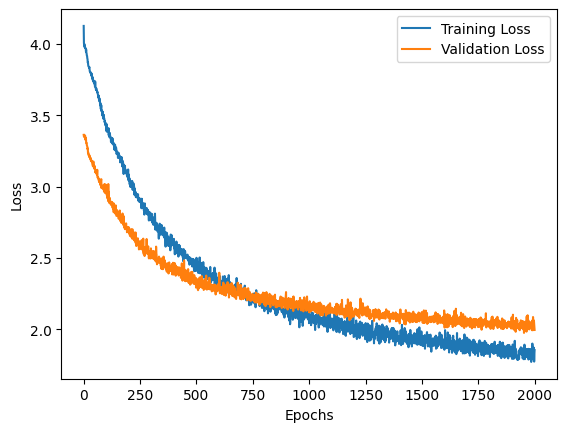

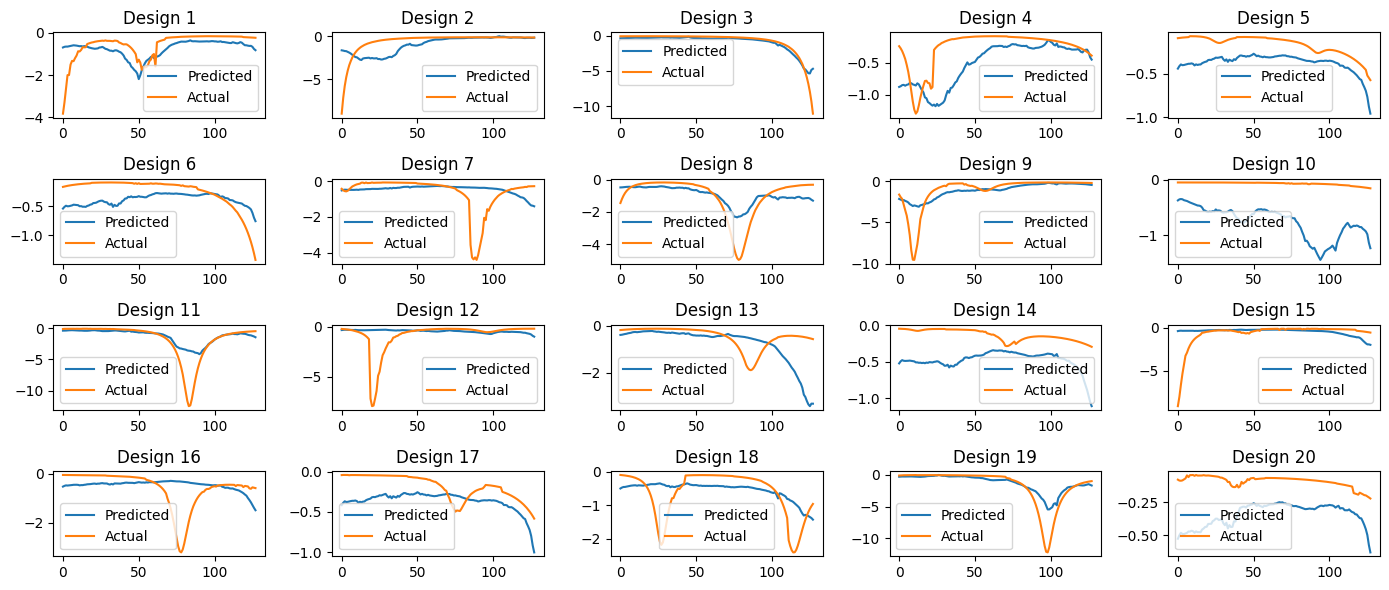

In [390]:
xx = xx
S11 = S11
input_dim = xx.shape[1]
output_dim = S11.shape[1]
model = BNN(input_dim, output_dim).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train and evaluate the model
train_losses, val_losses, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_full_dataset=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses, val_losses)
plot_results(model,test_loader)


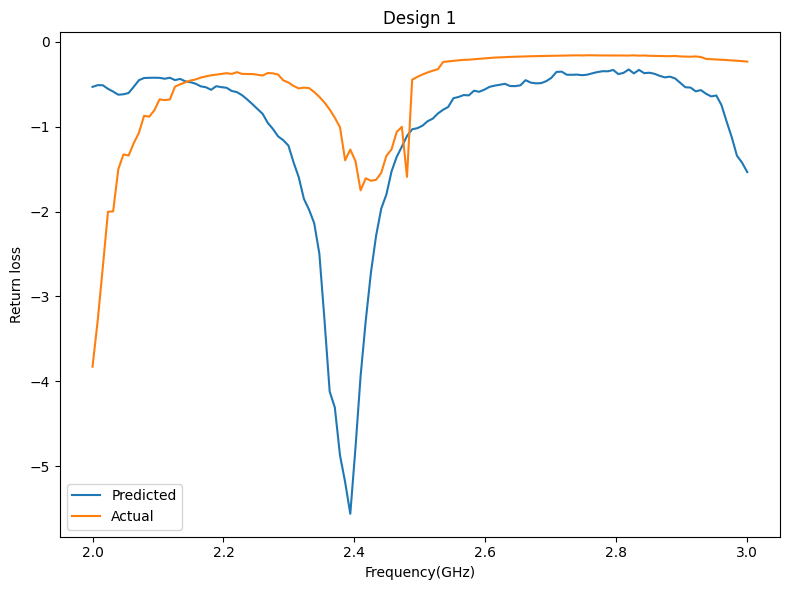

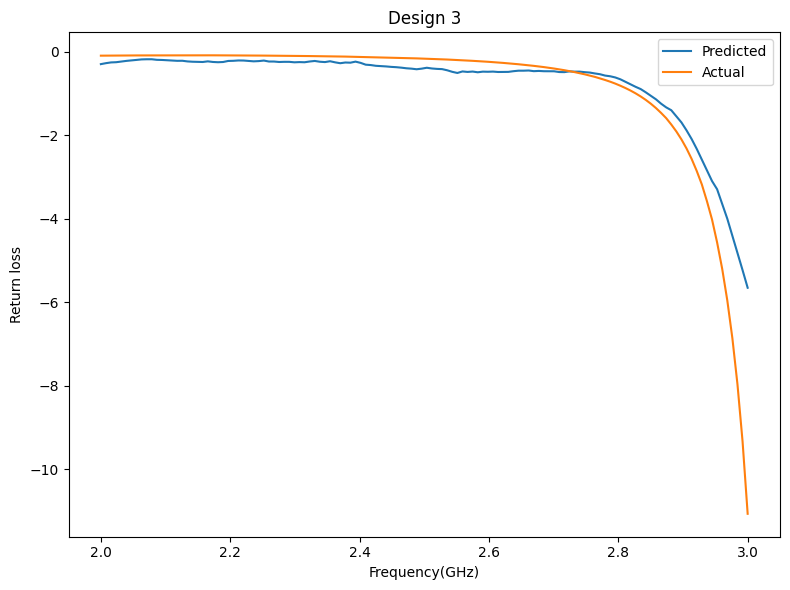

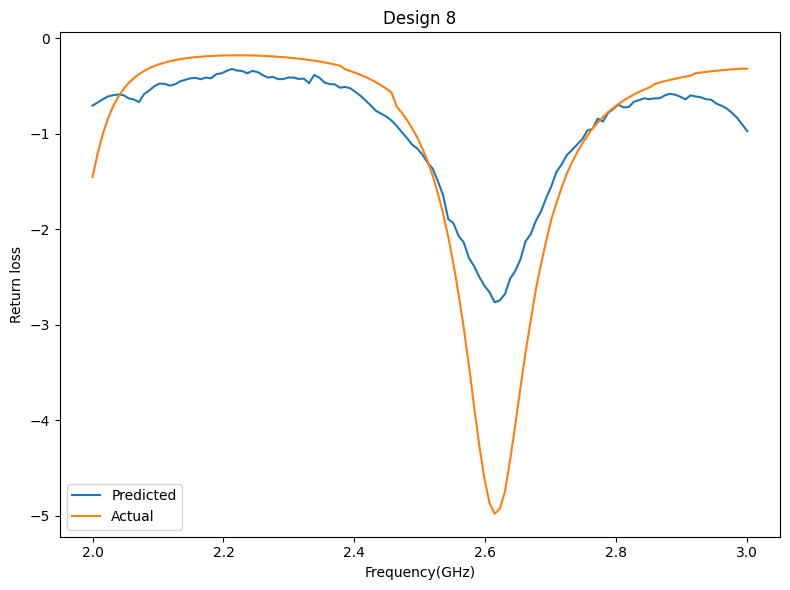

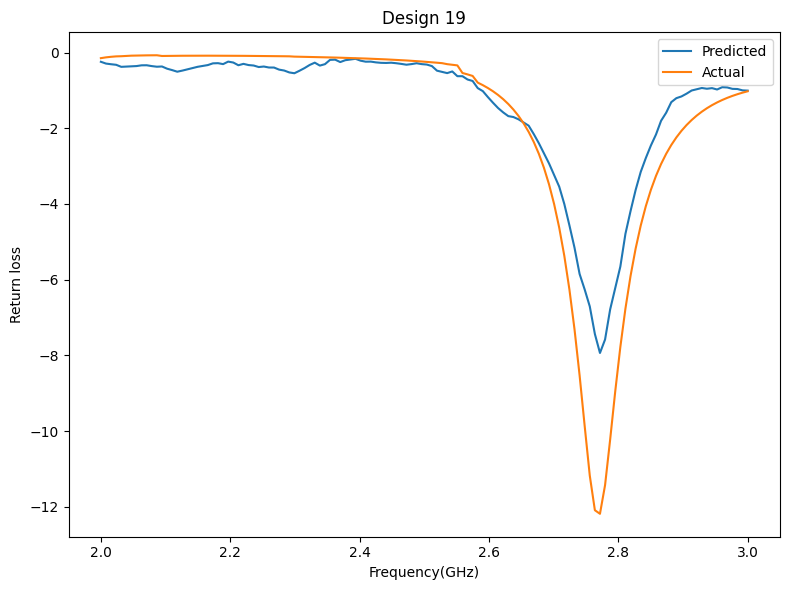

In [394]:
def plot_results2(model, validation_loader,i):
    model.eval()
    predicted = []
    actual = []

    with torch.no_grad():
        for data, targets in validation_loader:
            outputs = model(data)
            predicted.extend(outputs.numpy())
            actual.extend(targets.numpy())

    # Convert lists to numpy arrays for easier manipulation
    predicted = np.array(predicted).squeeze()
    actual = np.array(actual).squeeze()


    # Plotting the results
    plt.figure(figsize=(8, 6))
    freq =torch.linspace(2,3,128)
    plt.plot(freq,predicted[i], label='Predicted')
    plt.plot(freq,actual[i], label='Actual')
    plt.title(f'Design {i+1}')
    plt.xlabel('Frequency(GHz)')
    plt.ylabel('Return loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results2(model,test_loader,0)
plot_results2(model,test_loader,2)
plot_results2(model,test_loader,7)
plot_results2(model,test_loader,18)

Epoch 100/10000, Train Loss: 3.4516, Val Loss: 3.0149
Epoch 200/10000, Train Loss: 3.0758, Val Loss: 2.7453
Epoch 300/10000, Train Loss: 2.8241, Val Loss: 2.5900
Epoch 400/10000, Train Loss: 2.6244, Val Loss: 2.4515
Epoch 500/10000, Train Loss: 2.4754, Val Loss: 2.3857
Epoch 600/10000, Train Loss: 2.3889, Val Loss: 2.3336
Epoch 700/10000, Train Loss: 2.3226, Val Loss: 2.2974
Epoch 800/10000, Train Loss: 2.1981, Val Loss: 2.2977
Epoch 900/10000, Train Loss: 2.1220, Val Loss: 2.2403
Epoch 1000/10000, Train Loss: 2.0757, Val Loss: 2.1928
Epoch 1100/10000, Train Loss: 2.0088, Val Loss: 2.1710
Epoch 1200/10000, Train Loss: 2.0094, Val Loss: 2.1605
Epoch 1300/10000, Train Loss: 1.9679, Val Loss: 2.2070
Epoch 1400/10000, Train Loss: 1.9133, Val Loss: 2.1382
Epoch 1500/10000, Train Loss: 1.9153, Val Loss: 2.1196
Epoch 1600/10000, Train Loss: 1.8954, Val Loss: 2.1302
Epoch 1700/10000, Train Loss: 1.8536, Val Loss: 2.0984
Epoch 1800/10000, Train Loss: 1.8300, Val Loss: 2.0771
Epoch 1900/10000, T

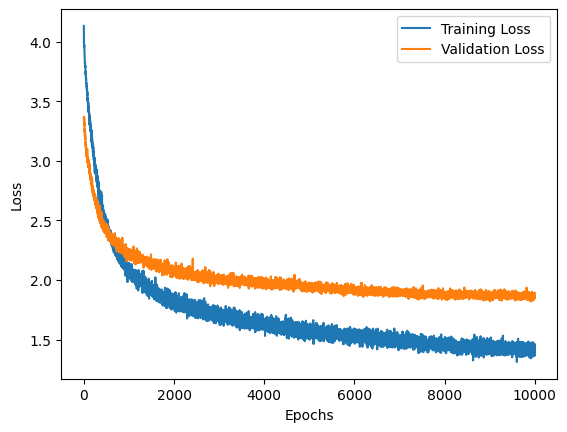

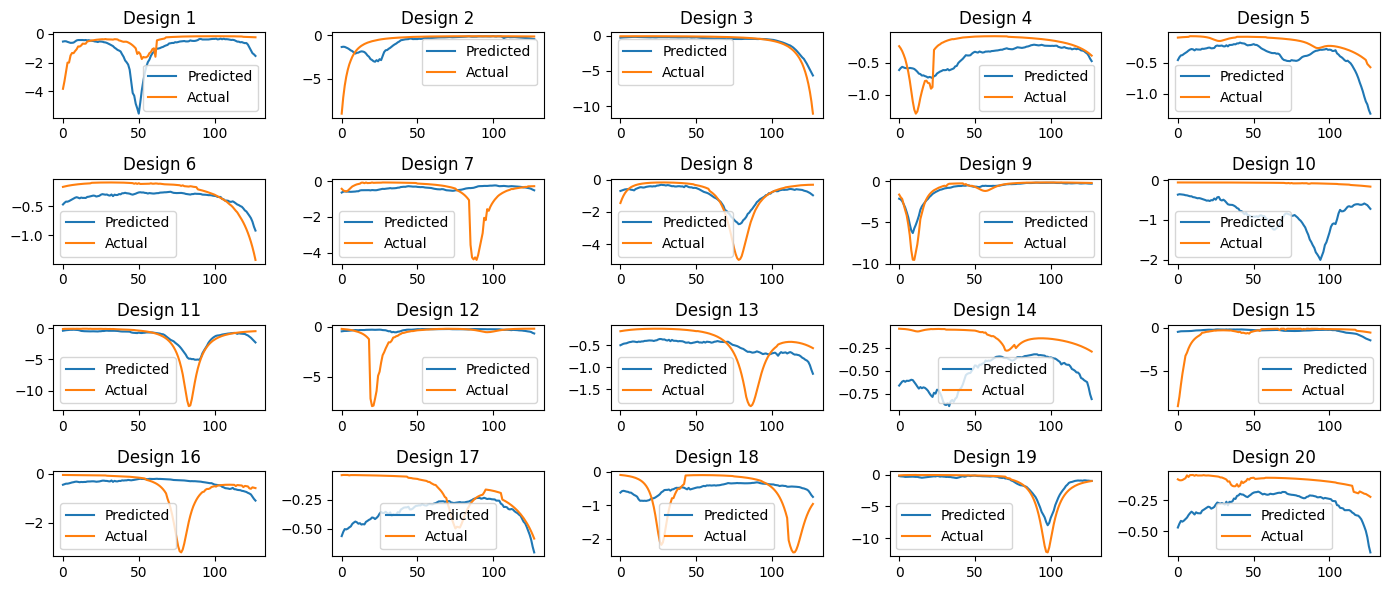

In [391]:
xx = xx
S11 = S11
input_dim = xx.shape[1]
output_dim = S11.shape[1]
model = BNN(input_dim, output_dim).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train and evaluate the model
train_losses, val_losses, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=10000, batch_size=32)
# evaluate the model
test_loss_full_dataset=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses, val_losses)
plot_results(model,test_loader)


# Model with random sampling for comparisom with AL

## initialize random samples

In [395]:
def initial_sampling(X, k):
    initial_indices = np.random.choice(range(len(X)), k, replace=False)
    unlabeled_indices = list(set(range(len(X))) - set(initial_indices))
    
    return initial_indices, unlabeled_indices



## define random sampling loop

In [321]:
def train_active_learning(model,criterion,optimizer,X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32,num_epochs=100):
    labeled_indices = list(initial_indices.copy())  # Convert to list to use append
    unlabeled_indices_new = unlabeled_indices.copy()
   
  
    train_losses = []
    val_losses = []

    for iteration in range(num_iterations):
        # Split labeled data into train and validation sets
        labeled_X = X[labeled_indices]
        labeled_y = y[labeled_indices]
        X_train = labeled_X
        y_train = labeled_y

        train_dataset = TensorDataset(X_train.clone().detach().to(dev), y_train.clone().detach().to(dev))
        val_dataset = TensorDataset(X_val.clone().detach().to(dev), y_val.clone().detach().to(dev))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        
        # Train the model for a number of epochs
        if(iteration!=num_iterations-1):
            num_epochs=1

        else:
            num_epochs=1
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            epoch_loss /= len(train_loader.dataset)

        train_losses.append(epoch_loss)

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Active learning step - Random Sampling
        if unlabeled_indices_new:
            next_index_relative = random.choice(unlabeled_indices_new)
            next_index = unlabeled_indices_new.pop(unlabeled_indices_new.index(next_index_relative))
            labeled_indices.append(next_index)
        
        if (iteration+1) % 100 == 0:
            print(f"Iteration {iteration+1}/{num_iterations}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f},Labeled indices count: {len(labeled_indices)}")


    return train_losses, val_losses, model, labeled_indices
        

## choose initial samples, train the model and get labeled indices

In [322]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]
model = BNN(input_dim, output_dim).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Initial sampling
initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)
# Active learning
train_losses_random, val_losses_random, model, labeled_indices = train_active_learning(model,criterion,optimizer,X_train, y_train, X_test, y_test, initial_indices, unlabeled_indices, num_iterations=1400, batch_size=32,num_epochs=10)
# Plotting losses
#plot_loss(train_losses_random, val_losses_random)

Iteration 100/1400, Train Loss: 3.8021, Val Loss: 3.5841,Labeled indices count: 200
Iteration 200/1400, Train Loss: 3.3163, Val Loss: 3.4839,Labeled indices count: 300
Iteration 300/1400, Train Loss: 3.2374, Val Loss: 3.4300,Labeled indices count: 400
Iteration 400/1400, Train Loss: 3.1151, Val Loss: 3.3735,Labeled indices count: 500
Iteration 500/1400, Train Loss: 3.1273, Val Loss: 3.2699,Labeled indices count: 600
Iteration 600/1400, Train Loss: 2.8166, Val Loss: 3.2101,Labeled indices count: 700
Iteration 700/1400, Train Loss: 2.8555, Val Loss: 3.1555,Labeled indices count: 800
Iteration 800/1400, Train Loss: 3.0640, Val Loss: 3.1181,Labeled indices count: 900
Iteration 900/1400, Train Loss: 2.8124, Val Loss: 3.0339,Labeled indices count: 1000
Iteration 1000/1400, Train Loss: 2.6556, Val Loss: 3.0472,Labeled indices count: 1100
Iteration 1100/1400, Train Loss: 2.4894, Val Loss: 2.9659,Labeled indices count: 1200
Iteration 1200/1400, Train Loss: 2.4300, Val Loss: 2.8346,Labeled indic

## see model's performance on labeled indices

Epoch 100/2000, Train Loss: 3.6842, Val Loss: 3.1795
Epoch 200/2000, Train Loss: 3.3331, Val Loss: 2.9991
Epoch 300/2000, Train Loss: 3.0203, Val Loss: 2.9219
Epoch 400/2000, Train Loss: 2.7530, Val Loss: 2.8073
Epoch 500/2000, Train Loss: 2.5720, Val Loss: 2.7639
Epoch 600/2000, Train Loss: 2.4228, Val Loss: 2.7184
Epoch 700/2000, Train Loss: 2.3536, Val Loss: 2.7158
Epoch 800/2000, Train Loss: 2.2092, Val Loss: 2.6550
Epoch 900/2000, Train Loss: 2.0650, Val Loss: 2.6203
Epoch 1000/2000, Train Loss: 2.1060, Val Loss: 2.5826
Epoch 1100/2000, Train Loss: 1.9794, Val Loss: 2.5600
Epoch 1200/2000, Train Loss: 1.8984, Val Loss: 2.5715
Epoch 1300/2000, Train Loss: 1.9143, Val Loss: 2.5102
Epoch 1400/2000, Train Loss: 1.8652, Val Loss: 2.5302
Epoch 1500/2000, Train Loss: 1.8830, Val Loss: 2.5125
Epoch 1600/2000, Train Loss: 1.7493, Val Loss: 2.5025
Epoch 1700/2000, Train Loss: 1.7858, Val Loss: 2.4923
Epoch 1800/2000, Train Loss: 1.7874, Val Loss: 2.4579
Epoch 1900/2000, Train Loss: 1.7115, 

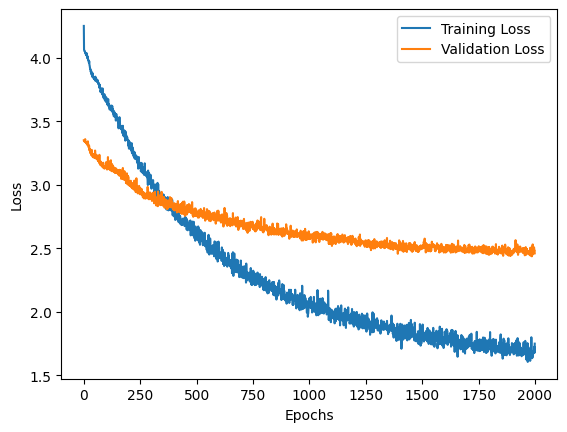

In [323]:
labeled_X = X_train[labeled_indices]
labeled_y = y_train[labeled_indices]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_random, val_losses_random, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_random=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_random, val_losses_random)


# Bayesian optimization with k-means clustering initialization

## Code for labeling initial indices using k-means clustering

In [379]:
def initial_sampling(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centroids = kmeans.cluster_centers_
    initial_indices = []
    for center in centroids:
        closest_index = np.argmin(np.linalg.norm(X - center, axis=1))
        initial_indices.append(closest_index)
    
    unlabeled_indices = list(set(range(len(X))) - set(initial_indices))
    
    return initial_indices, unlabeled_indices

# Initial sampling
initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)

## Codes for aquistition functions

In [439]:
# Acquisition functions implemented as separate functions
def expected_improvement(mean, std, best_y):
    z = (mean - best_y) / std
    return (mean - best_y) * norm.cdf(z) + std * norm.pdf(z)

def probability_of_improvement(mean_predictions, std_predictions, y_min, epsilon=1e-3):
    z = (mean_predictions - y_min - epsilon) / std_predictions
    pi = norm.cdf(z)
    return torch.tensor(pi, dtype=torch.float32)

def lower_confidence_bound(mean, std, kappa=1.0):
    return mean - kappa * std

def upper_confidence_bound(mean, std, beta=1.0):
    return mean + beta * std

## Dictionary to map acquisition function names to their implementations

In [440]:
acquisition_functions = {
    'ei': expected_improvement,
    'pi': probability_of_improvement,
    'lcb': lower_confidence_bound,
    'ucb': upper_confidence_bound
}

## Bayesian optimization loop with mc dropout

In [441]:
# Active Learning loop generalized for different acquisition functions
def train_bo(model,X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32, num_epochs=10, acq_func='pi'):
    labeled_indices = initial_indices.copy()
    unlabeled_indices_new=unlabeled_indices.copy()
    # Initialize the Bayesian Neural Network
    model = model.to(dev)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    


    train_losses = []
    val_losses = []

    for iteration in range(num_iterations):
        labeled_X = X[labeled_indices]
        labeled_y = y[labeled_indices]

        train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32).to(dev), torch.tensor(labeled_y, dtype=torch.float32).to(dev))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(dev), torch.tensor(y_val, dtype=torch.float32).to(dev))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            epoch_loss /= len(train_loader.dataset)

        train_losses.append(epoch_loss)

        # bayesian optimization with mc dropout
        with torch.no_grad():
            unlabeled_X = X[unlabeled_indices_new]
            unlabeled_X_tensor = torch.tensor(unlabeled_X, dtype=torch.float32).to(dev)
            # performing mc dropout
            outputs = torch.stack([model(unlabeled_X_tensor) for _ in range(10)], dim=0)
            mean = outputs.mean(dim=0).mean(dim=1)  # Aggregate over the multiple outputs
            std = outputs.std(dim=0).mean(dim=1)  # Aggregate over the multiple outputs
            
            # Use the best observed value from the labeled data
            best_y = labeled_y.min().item()

            # Select the acquisition function based on acq_func
            acq_func1 = acquisition_functions[acq_func]
            acquisition_values = acq_func1(mean, std, best_y)

            if acquisition_values.numel() > 0:
                next_index_relative = torch.argmax(acquisition_values).item()
                next_index = unlabeled_indices_new[next_index_relative]
                labeled_indices.append(next_index)
                unlabeled_indices_new.remove(next_index)
                
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        

        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}/{num_iterations}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Number of labeled indices: {len(labeled_indices)}")

    return train_losses, val_losses, model, labeled_indices

## Train model, get labeled indices and evaluate model on labeled indices

### Expected improvement 

In [442]:
xx = xx
S11 = S11

input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100
initial_indices1 = initial_indices
unlabeled_indices1= unlabeled_indices


# Initialize the Bayesian Neural Network
bnn_model = BNN(input_dim, output_dim)




# Train ith Bayesian Optimization
train_losses_, val_losses, bnn_model1, labeled_indices_ei = train_bo(
    bnn_model, X_train, y_train, X_val, y_val, initial_indices1, unlabeled_indices1,
    num_iterations=1400, batch_size=32, num_epochs=10, acq_func='ei'
)

Iteration 100/1400, Train Loss: 1.7944, Val Loss: 3.8313, Number of labeled indices: 200
Iteration 200/1400, Train Loss: 1.2164, Val Loss: 3.7697, Number of labeled indices: 300
Iteration 300/1400, Train Loss: 0.7303, Val Loss: 3.6572, Number of labeled indices: 400
Iteration 400/1400, Train Loss: 0.6648, Val Loss: 3.5125, Number of labeled indices: 500
Iteration 500/1400, Train Loss: 0.5966, Val Loss: 3.5261, Number of labeled indices: 600
Iteration 600/1400, Train Loss: 0.5953, Val Loss: 3.4086, Number of labeled indices: 700
Iteration 700/1400, Train Loss: 0.6364, Val Loss: 3.2618, Number of labeled indices: 800
Iteration 800/1400, Train Loss: 0.6267, Val Loss: 3.2649, Number of labeled indices: 900
Iteration 900/1400, Train Loss: 0.5860, Val Loss: 3.2192, Number of labeled indices: 1000
Iteration 1000/1400, Train Loss: 0.6009, Val Loss: 3.1231, Number of labeled indices: 1100
Iteration 1100/1400, Train Loss: 0.6584, Val Loss: 3.1152, Number of labeled indices: 1200
Iteration 1200/1

Epoch 100/2000, Train Loss: 1.7960, Val Loss: 3.3466
Epoch 200/2000, Train Loss: 1.6802, Val Loss: 3.3010
Epoch 300/2000, Train Loss: 1.6436, Val Loss: 3.2968
Epoch 400/2000, Train Loss: 1.5611, Val Loss: 3.2331
Epoch 500/2000, Train Loss: 1.5215, Val Loss: 3.2377
Epoch 600/2000, Train Loss: 1.4659, Val Loss: 3.2079
Epoch 700/2000, Train Loss: 1.4088, Val Loss: 3.1654
Epoch 800/2000, Train Loss: 1.3576, Val Loss: 3.2010
Epoch 900/2000, Train Loss: 1.3255, Val Loss: 3.1287
Epoch 1000/2000, Train Loss: 1.2981, Val Loss: 3.1314
Epoch 1100/2000, Train Loss: 1.3361, Val Loss: 3.0909
Epoch 1200/2000, Train Loss: 1.2632, Val Loss: 3.1495
Epoch 1300/2000, Train Loss: 1.2706, Val Loss: 3.0641
Epoch 1400/2000, Train Loss: 1.1983, Val Loss: 3.0469
Epoch 1500/2000, Train Loss: 1.1562, Val Loss: 3.0812
Epoch 1600/2000, Train Loss: 1.1757, Val Loss: 3.0390
Epoch 1700/2000, Train Loss: 1.1244, Val Loss: 3.0661
Epoch 1800/2000, Train Loss: 1.1109, Val Loss: 3.0628
Epoch 1900/2000, Train Loss: 1.1442, 

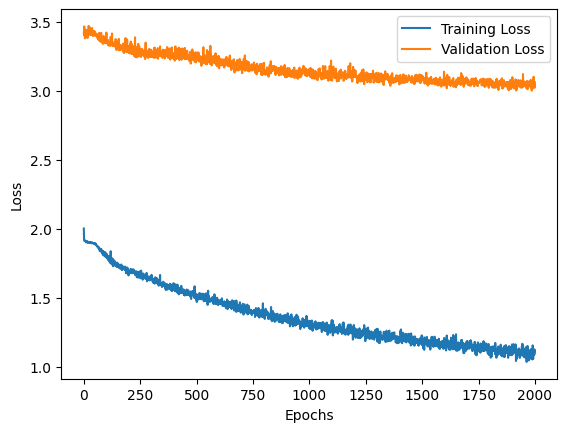

In [443]:
labeled_X = X_train[labeled_indices_ei]
labeled_y = y_train[labeled_indices_ei]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_ei, val_losses_ei, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_ei=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_ei, val_losses_ei)


### Upper Confidence Bound

In [444]:
xx = xx
S11 = S11

input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)
initial_indices2 = initial_indices
unlabeled_indices2= unlabeled_indices


# Initialize the Bayesian Neural Network
bnn_model = BNN(input_dim, output_dim).to(dev)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train ith Bayesian Optimization
train_losses_, val_losses, bnn_model1, labeled_indices_ucb = train_bo(
    bnn_model, X_train, y_train, X_val, y_val, initial_indices2, unlabeled_indices2,
    num_iterations=1400, batch_size=32, num_epochs=10, acq_func='ucb'
)

Iteration 100/1400, Train Loss: 1.7979, Val Loss: 3.8914, Number of labeled indices: 200
Iteration 200/1400, Train Loss: 1.0365, Val Loss: 3.7336, Number of labeled indices: 300
Iteration 300/1400, Train Loss: 0.9053, Val Loss: 3.6057, Number of labeled indices: 400
Iteration 400/1400, Train Loss: 0.7341, Val Loss: 3.4263, Number of labeled indices: 500
Iteration 500/1400, Train Loss: 0.6324, Val Loss: 3.3729, Number of labeled indices: 600
Iteration 600/1400, Train Loss: 0.6742, Val Loss: 3.3219, Number of labeled indices: 700
Iteration 700/1400, Train Loss: 0.6636, Val Loss: 3.2501, Number of labeled indices: 800
Iteration 800/1400, Train Loss: 0.7477, Val Loss: 3.1832, Number of labeled indices: 900
Iteration 900/1400, Train Loss: 0.6680, Val Loss: 3.1203, Number of labeled indices: 1000
Iteration 1000/1400, Train Loss: 0.7037, Val Loss: 3.1069, Number of labeled indices: 1100
Iteration 1100/1400, Train Loss: 0.6835, Val Loss: 2.9969, Number of labeled indices: 1200
Iteration 1200/1

Epoch 100/2500, Train Loss: 1.8592, Val Loss: 3.3401
Epoch 200/2500, Train Loss: 1.7496, Val Loss: 3.2716
Epoch 300/2500, Train Loss: 1.6211, Val Loss: 3.1763
Epoch 400/2500, Train Loss: 1.5331, Val Loss: 3.2044
Epoch 500/2500, Train Loss: 1.4872, Val Loss: 3.0773
Epoch 600/2500, Train Loss: 1.4302, Val Loss: 3.1018
Epoch 700/2500, Train Loss: 1.4079, Val Loss: 3.0517
Epoch 800/2500, Train Loss: 1.3334, Val Loss: 3.0487
Epoch 900/2500, Train Loss: 1.2997, Val Loss: 3.0382
Epoch 1000/2500, Train Loss: 1.2805, Val Loss: 3.0077
Epoch 1100/2500, Train Loss: 1.2506, Val Loss: 3.0293
Epoch 1200/2500, Train Loss: 1.2408, Val Loss: 3.0220
Epoch 1300/2500, Train Loss: 1.1608, Val Loss: 2.9462
Epoch 1400/2500, Train Loss: 1.1368, Val Loss: 3.0014
Epoch 1500/2500, Train Loss: 1.0868, Val Loss: 2.9912
Epoch 1600/2500, Train Loss: 1.1119, Val Loss: 2.9968
Epoch 1700/2500, Train Loss: 1.0842, Val Loss: 2.9595
Epoch 1800/2500, Train Loss: 1.0485, Val Loss: 2.9773
Epoch 1900/2500, Train Loss: 1.0447, 

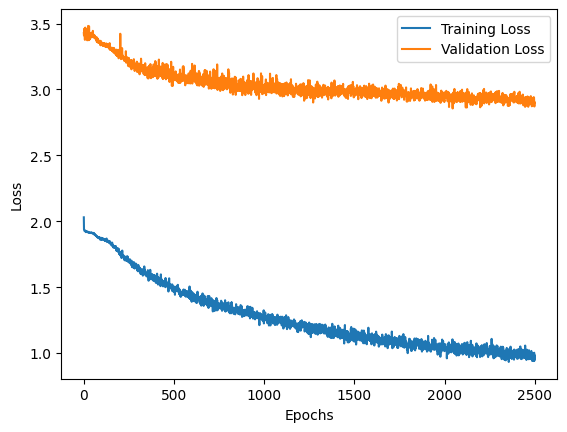

In [445]:
labeled_X = X_train[labeled_indices_ucb]
labeled_y = y_train[labeled_indices_ucb]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_ucb, val_losses_ucb, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2500, batch_size=32)
# evaluate the model
test_loss_ucb=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_ucb, val_losses_ucb)


### Lower Confidence Bound

In [446]:
xx = xx
S11 = S11

input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)
initial_indices3 = initial_indices
unlabeled_indices3= unlabeled_indices



# Initialize the Bayesian Neural Network
bnn_model = BNN(input_dim, output_dim).to(dev)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train ith Bayesian Optimization
train_losses_, val_losses, bnn_model1, labeled_indices_lcb = train_bo(
    bnn_model, X_train, y_train, X_val, y_val, initial_indices3, unlabeled_indices3,
    num_iterations=1400, batch_size=32, num_epochs=10, acq_func='lcb'
)

Iteration 100/1400, Train Loss: 4.4880, Val Loss: 3.2451, Number of labeled indices: 200
Iteration 200/1400, Train Loss: 3.2414, Val Loss: 3.1548, Number of labeled indices: 300
Iteration 300/1400, Train Loss: 3.0653, Val Loss: 2.9612, Number of labeled indices: 400
Iteration 400/1400, Train Loss: 2.6689, Val Loss: 2.7939, Number of labeled indices: 500
Iteration 500/1400, Train Loss: 2.4114, Val Loss: 2.6877, Number of labeled indices: 600
Iteration 600/1400, Train Loss: 2.3834, Val Loss: 2.6165, Number of labeled indices: 700
Iteration 700/1400, Train Loss: 2.3616, Val Loss: 2.5388, Number of labeled indices: 800
Iteration 800/1400, Train Loss: 2.4980, Val Loss: 2.4467, Number of labeled indices: 900
Iteration 900/1400, Train Loss: 2.1838, Val Loss: 2.3963, Number of labeled indices: 1000
Iteration 1000/1400, Train Loss: 2.2080, Val Loss: 2.3070, Number of labeled indices: 1100
Iteration 1100/1400, Train Loss: 2.0623, Val Loss: 2.2987, Number of labeled indices: 1200
Iteration 1200/1

Epoch 100/2000, Train Loss: 5.0188, Val Loss: 3.1422
Epoch 200/2000, Train Loss: 4.4225, Val Loss: 2.9185
Epoch 300/2000, Train Loss: 3.9301, Val Loss: 2.7258
Epoch 400/2000, Train Loss: 3.5413, Val Loss: 2.6567
Epoch 500/2000, Train Loss: 3.1985, Val Loss: 2.5783
Epoch 600/2000, Train Loss: 3.0254, Val Loss: 2.4994
Epoch 700/2000, Train Loss: 2.7915, Val Loss: 2.4396
Epoch 800/2000, Train Loss: 2.6517, Val Loss: 2.4016
Epoch 900/2000, Train Loss: 2.5403, Val Loss: 2.3458
Epoch 1000/2000, Train Loss: 2.4987, Val Loss: 2.3476
Epoch 1100/2000, Train Loss: 2.4184, Val Loss: 2.2809
Epoch 1200/2000, Train Loss: 2.3086, Val Loss: 2.2465
Epoch 1300/2000, Train Loss: 2.2163, Val Loss: 2.2789
Epoch 1400/2000, Train Loss: 2.2288, Val Loss: 2.2159
Epoch 1500/2000, Train Loss: 2.1416, Val Loss: 2.2323
Epoch 1600/2000, Train Loss: 2.1455, Val Loss: 2.2123
Epoch 1700/2000, Train Loss: 2.1874, Val Loss: 2.1900
Epoch 1800/2000, Train Loss: 2.1364, Val Loss: 2.1767
Epoch 1900/2000, Train Loss: 2.0118, 

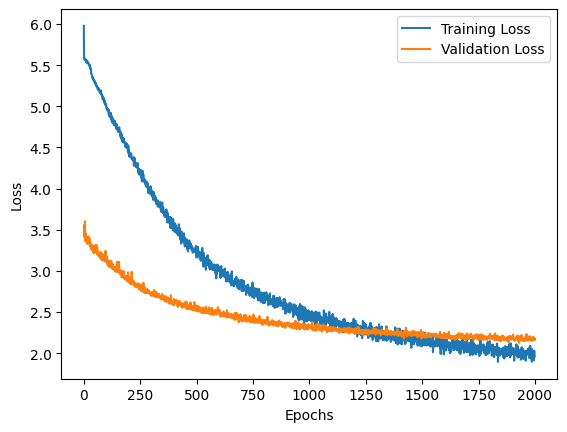

In [447]:
labeled_X = X_train[labeled_indices_lcb]
labeled_y = y_train[labeled_indices_lcb]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_lcb, val_losses_lcb, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_lcb=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_lcb, val_losses_lcb)


### Probability of Improvement 

In [448]:
xx = xx
S11 = S11

input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)
initial_indices4 = initial_indices
unlabeled_indices4= unlabeled_indices


# Initialize the Bayesian Neural Network
bnn_model = BNN(input_dim, output_dim).to(dev)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train ith Bayesian Optimization
train_losses_, val_losses, bnn_model1, labeled_indices_pi = train_bo(
    bnn_model, X_train, y_train, X_val, y_val, initial_indices4, unlabeled_indices4,
    num_iterations=1400, batch_size=32, num_epochs=10, acq_func='pi'
)

Iteration 100/1400, Train Loss: 2.2839, Val Loss: 3.5267, Number of labeled indices: 200
Iteration 200/1400, Train Loss: 1.6103, Val Loss: 3.4795, Number of labeled indices: 300
Iteration 300/1400, Train Loss: 1.5659, Val Loss: 3.3238, Number of labeled indices: 400
Iteration 400/1400, Train Loss: 1.3113, Val Loss: 3.2172, Number of labeled indices: 500
Iteration 500/1400, Train Loss: 1.3498, Val Loss: 3.1434, Number of labeled indices: 600
Iteration 600/1400, Train Loss: 1.4160, Val Loss: 3.0186, Number of labeled indices: 700
Iteration 700/1400, Train Loss: 1.3718, Val Loss: 2.9473, Number of labeled indices: 800
Iteration 800/1400, Train Loss: 1.3415, Val Loss: 2.9345, Number of labeled indices: 900
Iteration 900/1400, Train Loss: 1.3592, Val Loss: 2.9005, Number of labeled indices: 1000
Iteration 1000/1400, Train Loss: 1.3075, Val Loss: 2.7966, Number of labeled indices: 1100
Iteration 1100/1400, Train Loss: 1.3899, Val Loss: 2.7174, Number of labeled indices: 1200
Iteration 1200/1

Epoch 100/4000, Train Loss: 3.5559, Val Loss: 3.1407
Epoch 200/4000, Train Loss: 3.1600, Val Loss: 2.9905
Epoch 300/4000, Train Loss: 2.9144, Val Loss: 2.9167
Epoch 400/4000, Train Loss: 2.6742, Val Loss: 2.8338
Epoch 500/4000, Train Loss: 2.4973, Val Loss: 2.7920
Epoch 600/4000, Train Loss: 2.3446, Val Loss: 2.7260
Epoch 700/4000, Train Loss: 2.2205, Val Loss: 2.6760
Epoch 800/4000, Train Loss: 2.0478, Val Loss: 2.7034
Epoch 900/4000, Train Loss: 2.0250, Val Loss: 2.6648
Epoch 1000/4000, Train Loss: 1.8942, Val Loss: 2.6447
Epoch 1100/4000, Train Loss: 1.8645, Val Loss: 2.6089
Epoch 1200/4000, Train Loss: 1.8413, Val Loss: 2.5518
Epoch 1300/4000, Train Loss: 1.7041, Val Loss: 2.5724
Epoch 1400/4000, Train Loss: 1.7794, Val Loss: 2.5837
Epoch 1500/4000, Train Loss: 1.7180, Val Loss: 2.5610
Epoch 1600/4000, Train Loss: 1.6209, Val Loss: 2.5154
Epoch 1700/4000, Train Loss: 1.6487, Val Loss: 2.5420
Epoch 1800/4000, Train Loss: 1.5940, Val Loss: 2.5257
Epoch 1900/4000, Train Loss: 1.5908, 

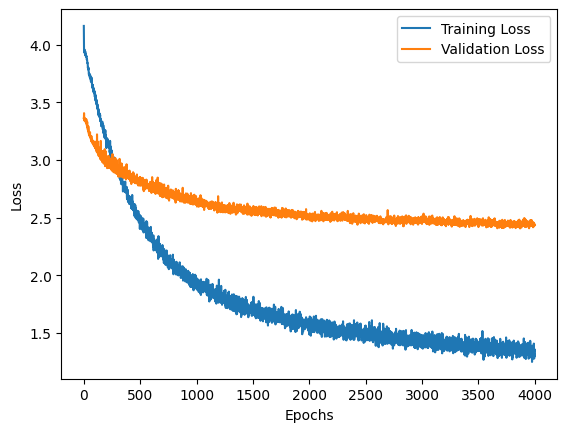

In [449]:
labeled_X = X_train[labeled_indices_pi]
labeled_y = y_train[labeled_indices_pi]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_pi, val_losses_pi, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=4000, batch_size=32)
# evaluate the model
test_loss_pi=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_pi, val_losses_pi)


In [450]:
len(initial_indices)

100

# QBC with k-mean clustering initialization

## Select initial labels with k-means clustering

In [347]:
# Function to initialize the labeled and unlabeled indices
def initial_sampling(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centroids = kmeans.cluster_centers_
    initial_indices = []
    for center in centroids:
        closest_index = np.argmin(np.linalg.norm(X - center, axis=1))
        initial_indices.append(closest_index)
    
    unlabeled_indices = list(set(range(len(X))) - set(initial_indices))
    
    return initial_indices, unlabeled_indices

## Code to create committee

In [366]:
# Function to create a committee of models
def create_committee(model,n_models=5):
    committee = [model for _ in range(n_models)]
    return committee

## Function to measure disagreement

In [367]:
# Measure disagreement among the committee
def measure_disagreement(committee, data, mode):
    predictions = []
    for model in committee:
        model.eval()
        with torch.no_grad():
            predictions.append(model(data).unsqueeze(0))
    predictions = torch.cat(predictions, dim=0)
    
    if mode == 'variance':
        disagreement = predictions.var(dim=0).mean(dim=1)
    elif mode == 'entropy':
        probs = F.softmax(predictions, dim=-1)
        avg_probs = probs.mean(dim=0)
        log_avg_probs = torch.log(avg_probs)
        entropy = -torch.sum(avg_probs * log_avg_probs, dim=1)
        disagreement = entropy
    elif mode == 'kl_divergence':
        probs = F.softmax(predictions, dim=-1)
        avg_probs = probs.mean(dim=0)
        kl_divs = torch.sum(probs * (torch.log(probs) - torch.log(avg_probs)), dim=-1)
        disagreement = kl_divs.mean(dim=0)
    return disagreement

## Active training loop with QBC 

In [374]:
# Training loop with QBC
def train_qbc(committee, X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32, num_epochs=10,mode='entropy'):
    labeled_indices = initial_indices.copy()
    unlabeled_indices_old = unlabeled_indices.copy()
    unlabeled_indices_new = list(set(unlabeled_indices_old) - set(labeled_indices))  # Ensure no overlap
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in committee]
    

    train_losses = []
    val_losses = []

    for iteration in range(num_iterations):
        # Validate indices are within bounds
        labeled_indices = [idx for idx in labeled_indices if idx < len(X)]
        unlabeled_indices = [idx for idx in unlabeled_indices if idx < len(X)]

        # Prepare data
        labeled_X = X[labeled_indices]
        labeled_y = y[labeled_indices]
        train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32).to(dev), torch.tensor(labeled_y, dtype=torch.float32).to(dev))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(dev), torch.tensor(y_val, dtype=torch.float32).to(dev))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train each model in the committee
        iteration_train_losses = []
        iteration_val_losses = []

        for model, optimizer in zip(committee, optimizers):
            model.train()
            train_epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_epoch_loss += loss.item() * inputs.size(0)
            train_epoch_loss /= len(train_loader.dataset)
            iteration_train_losses.append(train_epoch_loss)

            model.eval()
            val_epoch_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_outputs = model(val_inputs)
                    loss = criterion(val_outputs, val_targets)
                    val_epoch_loss += loss.item() * val_inputs.size(0)
            val_epoch_loss /= len(val_loader.dataset)
            iteration_val_losses.append(val_epoch_loss)

        # Average losses across all models for the current iteration
        avg_train_loss = np.mean(iteration_train_losses)
        avg_val_loss = np.mean(iteration_val_losses)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Measure disagreement and select the next instance
        if unlabeled_indices_new:
            unlabeled_X = X[unlabeled_indices_new]
            unlabeled_X_tensor = torch.tensor(unlabeled_X, dtype=torch.float32).to(dev)
            disagreement = measure_disagreement(committee, unlabeled_X_tensor,mode)

            if disagreement.numel() > 0:
                next_index_relative = torch.argmax(disagreement).item()
                next_index = unlabeled_indices_new[next_index_relative]
            else:
                continue

            labeled_indices.append(next_index)
            unlabeled_indices_new.remove(next_index)

        if (iteration+1) % 100 == 0:
            print(f"Iteration {iteration+1}/{num_iterations}, Last Train Loss: {train_losses[-1]:.4f}, Last Val Loss: {val_losses[-1]:.4f},Number of labeled indices: {len(labeled_indices)}")

    return train_losses, val_losses, committee , labeled_indices

## QBC with variance 

In [438]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)
initial_indices5 = initial_indices
unlabeled_indices5= unlabeled_indices


model = BNN(input_dim, output_dim, dropout_prob=0.3)

# Initialize Committee
committee = create_committee(model, n_models=5)

# Train with QBC
train_losses, val_losses, committee, labeled_indices_qbc_var = train_qbc(committee, X_train, y_train, X_val, y_val, initial_indices5, unlabeled_indices5, num_iterations=1400, batch_size=32, num_epochs=10,mode='variance')


Iteration 100/1400, Last Train Loss: 3.1004, Last Val Loss: 3.3406,Number of labeled indices: 200
Iteration 200/1400, Last Train Loss: 2.8875, Last Val Loss: 3.3901,Number of labeled indices: 300
Iteration 300/1400, Last Train Loss: 2.3153, Last Val Loss: 3.3381,Number of labeled indices: 400
Iteration 400/1400, Last Train Loss: 2.0115, Last Val Loss: 3.2876,Number of labeled indices: 500
Iteration 500/1400, Last Train Loss: 1.7439, Last Val Loss: 3.1992,Number of labeled indices: 600
Iteration 600/1400, Last Train Loss: 1.7728, Last Val Loss: 3.0858,Number of labeled indices: 700
Iteration 700/1400, Last Train Loss: 1.6633, Last Val Loss: 3.0350,Number of labeled indices: 800
Iteration 800/1400, Last Train Loss: 1.7529, Last Val Loss: 2.9717,Number of labeled indices: 900
Iteration 900/1400, Last Train Loss: 1.7081, Last Val Loss: 2.9437,Number of labeled indices: 1000
Iteration 1000/1400, Last Train Loss: 1.7726, Last Val Loss: 2.8370,Number of labeled indices: 1100
Iteration 1100/14

Epoch 100/4000, Train Loss: 3.5477, Val Loss: 3.0582
Epoch 200/4000, Train Loss: 3.1748, Val Loss: 2.9564
Epoch 300/4000, Train Loss: 2.9169, Val Loss: 2.8755
Epoch 400/4000, Train Loss: 2.7159, Val Loss: 2.7811
Epoch 500/4000, Train Loss: 2.5226, Val Loss: 2.7338
Epoch 600/4000, Train Loss: 2.3516, Val Loss: 2.6319
Epoch 700/4000, Train Loss: 2.2367, Val Loss: 2.6067
Epoch 800/4000, Train Loss: 2.1050, Val Loss: 2.5289
Epoch 900/4000, Train Loss: 2.1667, Val Loss: 2.5311
Epoch 1000/4000, Train Loss: 2.0662, Val Loss: 2.4670
Epoch 1100/4000, Train Loss: 1.9772, Val Loss: 2.4523
Epoch 1200/4000, Train Loss: 1.9429, Val Loss: 2.4882
Epoch 1300/4000, Train Loss: 1.8705, Val Loss: 2.4429
Epoch 1400/4000, Train Loss: 1.8548, Val Loss: 2.4409
Epoch 1500/4000, Train Loss: 1.8032, Val Loss: 2.4315
Epoch 1600/4000, Train Loss: 1.7784, Val Loss: 2.4025
Epoch 1700/4000, Train Loss: 1.7039, Val Loss: 2.3886
Epoch 1800/4000, Train Loss: 1.7097, Val Loss: 2.3759
Epoch 1900/4000, Train Loss: 1.6719, 

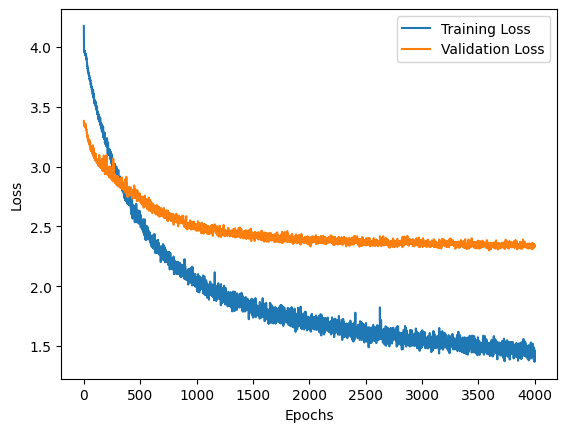

In [397]:
labeled_X = X_train[labeled_indices_qbc_var]
labeled_y = y_train[labeled_indices_qbc_var]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_qbc_variance, val_losses_qbc_variance, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=4000, batch_size=32)
# evaluate the model
test_loss_qbc_variance=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_qbc_variance, val_losses_qbc_variance)


## QBC with KL-Divergence

In [436]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100) 
initial_indices6 = initial_indices
unlabeled_indices6= unlabeled_indices


model = BNN(input_dim, output_dim, dropout_prob=0.3)

# Initialize Committee
committee = create_committee(model, n_models=5)

# Train with QBC
train_losses, val_losses, committee, labeled_indices_qbc_kl = train_qbc(committee, X_train, y_train, X_val, y_val, initial_indices6, unlabeled_indices6, num_iterations=1400, batch_size=32, num_epochs=10,mode='kl_divergence')


Iteration 100/1400, Last Train Loss: 3.3971, Last Val Loss: 3.3126,Number of labeled indices: 200
Iteration 200/1400, Last Train Loss: 3.4284, Last Val Loss: 3.3907,Number of labeled indices: 300
Iteration 300/1400, Last Train Loss: 3.3004, Last Val Loss: 3.1918,Number of labeled indices: 400
Iteration 400/1400, Last Train Loss: 3.0632, Last Val Loss: 3.1304,Number of labeled indices: 500
Iteration 500/1400, Last Train Loss: 2.7948, Last Val Loss: 3.0007,Number of labeled indices: 600
Iteration 600/1400, Last Train Loss: 2.5960, Last Val Loss: 2.8707,Number of labeled indices: 700
Iteration 700/1400, Last Train Loss: 2.5713, Last Val Loss: 2.7724,Number of labeled indices: 800
Iteration 800/1400, Last Train Loss: 2.5277, Last Val Loss: 2.7401,Number of labeled indices: 900
Iteration 900/1400, Last Train Loss: 2.3277, Last Val Loss: 2.6594,Number of labeled indices: 1000
Iteration 1000/1400, Last Train Loss: 2.1858, Last Val Loss: 2.6178,Number of labeled indices: 1100
Iteration 1100/14

Epoch 100/2000, Train Loss: 4.4469, Val Loss: 3.0619
Epoch 200/2000, Train Loss: 4.0056, Val Loss: 2.8955
Epoch 300/2000, Train Loss: 3.5486, Val Loss: 2.7665
Epoch 400/2000, Train Loss: 3.2531, Val Loss: 2.6998
Epoch 500/2000, Train Loss: 2.9722, Val Loss: 2.6689
Epoch 600/2000, Train Loss: 2.8071, Val Loss: 2.6100
Epoch 700/2000, Train Loss: 2.6585, Val Loss: 2.5512
Epoch 800/2000, Train Loss: 2.4455, Val Loss: 2.5174
Epoch 900/2000, Train Loss: 2.4037, Val Loss: 2.5076
Epoch 1000/2000, Train Loss: 2.3129, Val Loss: 2.4692
Epoch 1100/2000, Train Loss: 2.2670, Val Loss: 2.4376
Epoch 1200/2000, Train Loss: 2.2357, Val Loss: 2.4291
Epoch 1300/2000, Train Loss: 2.1601, Val Loss: 2.3823
Epoch 1400/2000, Train Loss: 2.1217, Val Loss: 2.3601
Epoch 1500/2000, Train Loss: 2.0037, Val Loss: 2.3714
Epoch 1600/2000, Train Loss: 2.1038, Val Loss: 2.3728
Epoch 1700/2000, Train Loss: 1.9696, Val Loss: 2.3181
Epoch 1800/2000, Train Loss: 1.8642, Val Loss: 2.3280
Epoch 1900/2000, Train Loss: 1.9196, 

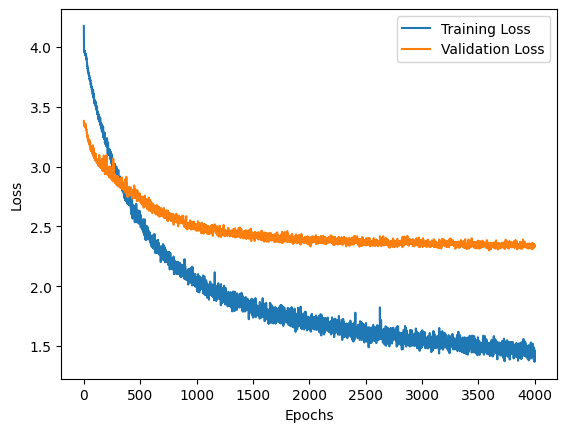

In [437]:
labeled_X = X_train[labeled_indices_qbc_kl]
labeled_y = y_train[labeled_indices_qbc_kl]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_qbc_kl_divergence, val_losses_qbc_kl_divergence, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_qbc_kl_divergence=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_qbc_variance, val_losses_qbc_variance)


# BALD

## Define the BALD Acquisition Function

In [398]:
def bald_acquisition_function(outputs):
    # Calculate the predictive entropy
    predictive_entropy = -torch.mean(torch.logsumexp(outputs, dim=0) - torch.log(torch.tensor(outputs.shape[0])))

    # Calculate the expected entropy
    expected_entropy = -torch.mean(torch.sum(outputs * torch.log(outputs + 1e-10), dim=2), dim=0)

    # BALD is the difference between predictive entropy and expected entropy
    acquisition_values = predictive_entropy - expected_entropy
    return acquisition_values


## BALD AL LOOP

In [407]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assuming your model and other setup code are defined here

def train_bo(model, X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32, num_epochs=10):
    labeled_indices = initial_indices.copy()
    unlabeled_indices_new = unlabeled_indices.copy()
    
    # Initialize the Bayesian Neural Network
    model = model.to(dev)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for iteration in range(num_iterations):
        labeled_X = X[labeled_indices]
        labeled_y = y[labeled_indices]

        train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32).to(dev), torch.tensor(labeled_y, dtype=torch.float32).to(dev))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(dev), torch.tensor(y_val, dtype=torch.float32).to(dev))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            epoch_loss /= len(train_loader.dataset)

        train_losses.append(epoch_loss)

        # Bayesian optimization with mc dropout
        model.eval()
        with torch.no_grad():
            unlabeled_X = X[unlabeled_indices_new]
            unlabeled_X_tensor = torch.tensor(unlabeled_X, dtype=torch.float32).to(dev)
            
            # Performing MC dropout
            outputs = torch.stack([F.softmax(model(unlabeled_X_tensor), dim=1) for _ in range(50)], dim=0)
            
            # Compute BALD acquisition values
            acquisition_values = bald_acquisition_function(outputs)

            if acquisition_values.numel() > 0:
                next_index_relative = torch.argmax(acquisition_values).item()
                next_index = unlabeled_indices_new[next_index_relative]
                labeled_indices.append(next_index)
                unlabeled_indices_new.remove(next_index)

        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}/{num_iterations}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Number of labeled indices: {len(labeled_indices)}")

    return train_losses, val_losses, model, labeled_indices


In [410]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100) 
initial_indices7 = initial_indices
unlabeled_indices7= unlabeled_indices


model = BNN(input_dim, output_dim, dropout_prob=0.3)



# Train with BALD
train_losses, val_losses, committee, labeled_indices_bald = train_bo(model, X_train, y_train, X_val, y_val, initial_indices7, unlabeled_indices7, num_iterations=1300, batch_size=32, num_epochs=10)


Iteration 100/1300, Train Loss: 3.3587, Val Loss: 3.2972, Number of labeled indices: 200
Iteration 200/1300, Train Loss: 3.0233, Val Loss: 3.2268, Number of labeled indices: 300
Iteration 300/1300, Train Loss: 2.6615, Val Loss: 3.0830, Number of labeled indices: 400
Iteration 400/1300, Train Loss: 2.4345, Val Loss: 2.9337, Number of labeled indices: 500
Iteration 500/1300, Train Loss: 2.3583, Val Loss: 2.8277, Number of labeled indices: 600
Iteration 600/1300, Train Loss: 2.3170, Val Loss: 2.7489, Number of labeled indices: 700
Iteration 700/1300, Train Loss: 2.2744, Val Loss: 2.6554, Number of labeled indices: 800
Iteration 800/1300, Train Loss: 2.3611, Val Loss: 2.5796, Number of labeled indices: 900
Iteration 900/1300, Train Loss: 2.3216, Val Loss: 2.4705, Number of labeled indices: 1000
Iteration 1000/1300, Train Loss: 2.2884, Val Loss: 2.4388, Number of labeled indices: 1100
Iteration 1100/1300, Train Loss: 2.1183, Val Loss: 2.4157, Number of labeled indices: 1200
Iteration 1200/1

Epoch 100/5000, Train Loss: 5.3284, Val Loss: 3.2016
Epoch 200/5000, Train Loss: 4.6999, Val Loss: 2.8920
Epoch 300/5000, Train Loss: 4.1355, Val Loss: 2.7384
Epoch 400/5000, Train Loss: 3.7912, Val Loss: 2.6195
Epoch 500/5000, Train Loss: 3.4134, Val Loss: 2.5606
Epoch 600/5000, Train Loss: 3.1283, Val Loss: 2.5035
Epoch 700/5000, Train Loss: 2.9801, Val Loss: 2.4602
Epoch 800/5000, Train Loss: 2.8204, Val Loss: 2.4544
Epoch 900/5000, Train Loss: 2.6311, Val Loss: 2.3863
Epoch 1000/5000, Train Loss: 2.5425, Val Loss: 2.3710
Epoch 1100/5000, Train Loss: 2.4738, Val Loss: 2.3283
Epoch 1200/5000, Train Loss: 2.3575, Val Loss: 2.3439
Epoch 1300/5000, Train Loss: 2.3236, Val Loss: 2.2900
Epoch 1400/5000, Train Loss: 2.2832, Val Loss: 2.2990
Epoch 1500/5000, Train Loss: 2.2944, Val Loss: 2.3081
Epoch 1600/5000, Train Loss: 2.1935, Val Loss: 2.2621
Epoch 1700/5000, Train Loss: 2.2216, Val Loss: 2.2772
Epoch 1800/5000, Train Loss: 2.1521, Val Loss: 2.2335
Epoch 1900/5000, Train Loss: 2.0509, 

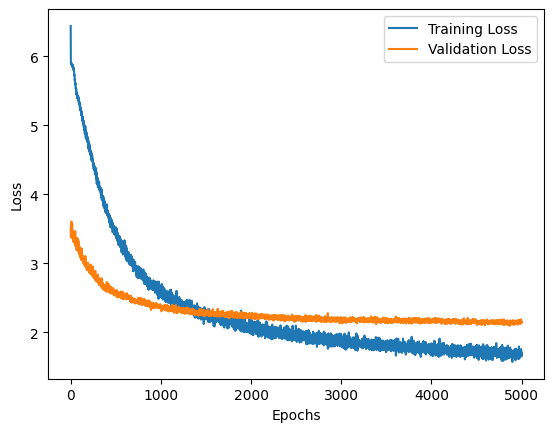

In [414]:
labeled_X = X_train[labeled_indices_bald]
labeled_y = y_train[labeled_indices_bald]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_bald, val_losses_bald, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=5000, batch_size=32)
# evaluate the model
test_loss_bald=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_bald, val_losses_bald)


# EMCM

In [433]:

def calculate_gradient_norm(model, data, target):
    model.train()  # Ensure the model is in training mode to calculate gradients
    optimizer.zero_grad()
    prediction = model(data)
    loss = criterion(prediction, target)
    loss.backward()
    grad_norm = sum(p.grad.norm().item() ** 2 for p in model.parameters() if p.grad is not None)
    return grad_norm ** 0.5

def emcm_selection(model, unlabeled_data, num_to_select=1):
    model.eval()  # Ensure the model is in evaluation mode when making predictions
    gradients = []
    
    for data in unlabeled_data:
        if isinstance(data, torch.Tensor):
            data_tensor = data.unsqueeze(0).to(device)
        else:
            data_tensor = torch.tensor([data], dtype=torch.float).to(device)
        
        # Temporarily enable gradients to calculate gradient norm
        data_tensor.requires_grad_(True)
        optimizer.zero_grad()
        prediction = model(data_tensor)
        loss = criterion(prediction, torch.zeros_like(prediction))  # Assuming a placeholder zero target
        loss.backward()
        grad_norm = data_tensor.grad.norm().item()
        gradients.append(grad_norm)
        data_tensor.requires_grad_(False)  # Turn off gradients for data_tensor

    # Convert list to tensor for efficient computation
    gradients = torch.tensor(gradients)
    selected_indices = gradients.topk(num_to_select).indices
    return selected_indices.tolist()


def train_bo(model, X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, y, X_val, y_val = map(lambda z: torch.tensor(z, dtype=torch.float).to(device), [X, y, X_val, y_val])
    labeled_indices = list(initial_indices)
    unlabeled_indices_new = list(unlabeled_indices)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    for iteration in range(num_iterations):
        # Train model on currently labeled data
        train_dataset = TensorDataset(X[labeled_indices], y[labeled_indices])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()* inputs.size(0)
            train_losses.append(total_loss / len(train_loader.dataset))

        # Select new indices via EMCM
        unlabeled_data = X[unlabeled_indices_new]
        selected_indices = emcm_selection(model, unlabeled_data)
        labeled_indices.extend([unlabeled_indices_new[i] for i in selected_indices])
        unlabeled_indices_new = [idx for idx in unlabeled_indices_new if idx not in selected_indices]

        # Validation
        model.eval()
        total_val_loss = 0
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_val_loss += loss.item()* data.size(0)
        val_losses.append(total_val_loss / len(val_loader.dataset))

        if (iteration+1)%100==0:
            print(f"Iteration {iteration + 1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Labeled indices count: {len(labeled_indices)}")
                
    return train_losses, val_losses, model, labeled_indices



In [434]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100) 
initial_indices8 = initial_indices
unlabeled_indices8= unlabeled_indices


model = BNN(input_dim, output_dim, dropout_prob=0.3)


# Train with 
train_losses, val_losses, committee, labeled_indices_emcm = train_bo(model, X_train, y_train, X_val, y_val, initial_indices8, unlabeled_indices8, num_iterations=1300, batch_size=32, num_epochs=10)


Iteration 100: Train Loss: 1.5274, Val Loss: 3.4051, Labeled indices count: 200
Iteration 200: Train Loss: 1.3859, Val Loss: 3.3763, Labeled indices count: 300
Iteration 300: Train Loss: 1.2183, Val Loss: 3.2576, Labeled indices count: 400
Iteration 400: Train Loss: 1.1686, Val Loss: 3.1793, Labeled indices count: 500
Iteration 500: Train Loss: 1.3019, Val Loss: 3.1417, Labeled indices count: 600
Iteration 600: Train Loss: 1.2354, Val Loss: 3.1937, Labeled indices count: 700
Iteration 700: Train Loss: 1.3786, Val Loss: 3.1545, Labeled indices count: 800
Iteration 800: Train Loss: 1.5794, Val Loss: 3.1305, Labeled indices count: 900
Iteration 900: Train Loss: 1.6604, Val Loss: 3.0633, Labeled indices count: 1000
Iteration 1000: Train Loss: 1.5828, Val Loss: 3.0053, Labeled indices count: 1100
Iteration 1100: Train Loss: 1.6344, Val Loss: 2.9982, Labeled indices count: 1200
Iteration 1200: Train Loss: 1.7549, Val Loss: 2.9504, Labeled indices count: 1300
Iteration 1300: Train Loss: 1.699

Epoch 100/5000, Train Loss: 6.6527, Val Loss: 3.7239
Epoch 200/5000, Train Loss: 3.9336, Val Loss: 3.2902
Epoch 300/5000, Train Loss: 3.1075, Val Loss: 3.1616
Epoch 400/5000, Train Loss: 2.6208, Val Loss: 3.0631
Epoch 500/5000, Train Loss: 2.2287, Val Loss: 3.0552
Epoch 600/5000, Train Loss: 2.0436, Val Loss: 2.9682
Epoch 700/5000, Train Loss: 1.9101, Val Loss: 2.9445
Epoch 800/5000, Train Loss: 1.7972, Val Loss: 2.9338
Epoch 900/5000, Train Loss: 1.7130, Val Loss: 2.8991
Epoch 1000/5000, Train Loss: 1.6401, Val Loss: 2.9062
Epoch 1100/5000, Train Loss: 1.5842, Val Loss: 2.8963
Epoch 1200/5000, Train Loss: 1.5878, Val Loss: 2.9123
Epoch 1300/5000, Train Loss: 1.5174, Val Loss: 2.8940
Epoch 1400/5000, Train Loss: 1.4497, Val Loss: 2.8911
Epoch 1500/5000, Train Loss: 1.4444, Val Loss: 2.8296
Epoch 1600/5000, Train Loss: 1.5148, Val Loss: 2.8553
Epoch 1700/5000, Train Loss: 1.4638, Val Loss: 2.8611
Epoch 1800/5000, Train Loss: 1.4160, Val Loss: 2.8725
Epoch 1900/5000, Train Loss: 1.3700, 

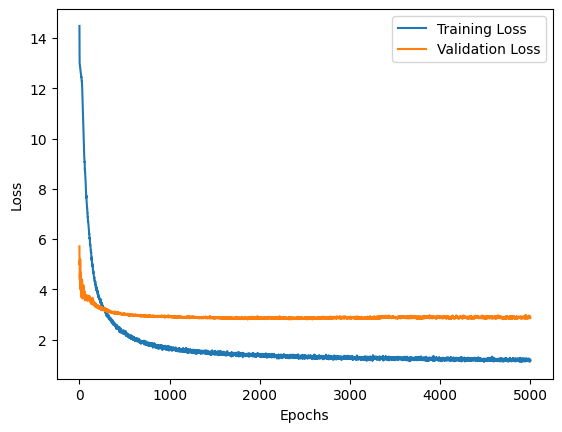

In [435]:
labeled_X = X_train[labeled_indices_emcm]
labeled_y = y_train[labeled_indices_emcm]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_emcm, val_losses_emcm, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=5000, batch_size=32)
# evaluate the model
test_loss_emcm=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_emcm, val_losses_emcm)


# Uncertainity Sampling with entropy with k-means clustering initialization

## Initialize labeled indices with k-means clustering

In [ ]:
# Function to initialize the labeled and unlabeled indices
def initial_sampling(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centroids = kmeans.cluster_centers_
    initial_indices = []
    for center in centroids:
        closest_index = np.argmin(np.linalg.norm(X - center, axis=1))
        initial_indices.append(closest_index)
    
    unlabeled_indices = list(set(range(len(X))) - set(initial_indices))
    
    return initial_indices, unlabeled_indices

## Uncertainity Measuring Method

In [ ]:
def uncertainities(outputs,method='uncertainity'):
    if method=='uncertainity':
        uncertainties = -torch.sum(F.softmax(outputs, dim=1) * torch.log(F.softmax(outputs, dim=1)), dim=1)

    elif method=='least_confidence':
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        uncertainties = 1 - probabilities.max(dim=1)[0]
    return uncertainities

## Uncertainity Sampling Loop

In [ ]:
def train_greedy_sampling(model,method, X, y, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=100, batch_size=32, num_epochs=10):
    labeled_indices = initial_indices.copy()
    unlabeled_indices = list(set(unlabeled_indices) - set(labeled_indices))  # Ensure no overlap and correct indices

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for iteration in range(num_iterations):
        # Validate indices are within bounds
        labeled_indices = [idx for idx in labeled_indices if idx < len(X)]
        unlabeled_indices = [idx for idx in unlabeled_indices if idx < len(X)]

        labeled_X = X[labeled_indices]
        labeled_y = y[labeled_indices]
        train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Greedy sampling based on uncertainty or prediction error
        if unlabeled_indices:
            model.eval()
            with torch.no_grad():
                unlabeled_X = X[unlabeled_indices]
                unlabeled_X_tensor = torch.tensor(unlabeled_X, dtype=torch.float32)
                outputs = model(unlabeled_X_tensor)
                # Assuming a method to calculate uncertainty or loss
                if method=='uncertainity':
                    uncertainities = -torch.sum(F.softmax(outputs, dim=1) * torch.log(F.softmax(outputs, dim=1)), dim=1)

                elif method=='kl_divergence':
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    uncertainities = 1 - probabilities.max(dim=1)[0]
                
                 

            next_index_relative = torch.argmax(uncertainities).item()
            next_index = unlabeled_indices[next_index_relative]
            labeled_indices.append(next_index)
            unlabeled_indices.remove(next_index)

        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}/{num_iterations}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses, model, labeled_indices

## Uncertainity sampling with unceratinity

In [ ]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)    

model1 = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

method = 'uncertainity'

# Train with greedy sampling
train_losses, val_losses, model1, labeled_indices = train_greedy_sampling(model1,method, X_train, y_train, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=1400, batch_size=32, num_epochs=10)


In [ ]:
labeled_X = X_train[labeled_indices]
labeled_y = y_train[labeled_indices]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_uncertainity_uncertainity, val_losses_uncertainity_uncertainity, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_uncertainity_uncertainity=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_uncertainity_uncertainity, val_losses_uncertainity_uncertainity)


# Uncertainity Sampling with LEAST CONFIDENCE with k-means clustering initialization

In [ ]:
input_dim = xx.shape[1]
output_dim = S11.shape[1]

# Ensure device is set
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initial sampling
# initial_indices, unlabeled_indices = initial_sampling(X_train, k=100)    

model1 = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

method = 'kl_divergence'

# Train with greedy sampling
train_losses, val_losses, model1, labeled_indices = train_greedy_sampling(model1,method, X_train, y_train, X_val, y_val, initial_indices, unlabeled_indices, num_iterations=1400, batch_size=32, num_epochs=10)


In [ ]:
labeled_X = X_train[labeled_indices]
labeled_y = y_train[labeled_indices]

# Convert data to PyTorch tensors and define a DataLoader
train_dataset = TensorDataset(torch.tensor(labeled_X, dtype=torch.float32), torch.tensor(labeled_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = labeled_X.shape[1]
output_dim = labeled_y.shape[1]

model = BNN(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_uncertainity_kl_divergence, val_losses_uncertainity_kl_divergence, model = train_and_evaluate(model,criterion,optimizer,train_loader, val_loader, num_epochs=2000, batch_size=32)
# evaluate the model
test_loss_uncertainity_least_confidence=evaluate_model(model, test_loader)
# Plotting losses
plot_loss(train_losses_uncertainity_kl_divergence, val_losses_uncertainity_kl_divergence)
